<a href="https://colab.research.google.com/github/iamrajatroy/Data-Science-Lab/blob/main/FairLearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install fairlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Package Imports

In [40]:
import json

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from fairlearn.datasets import fetch_adult
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio
from fairlearn.reductions import DemographicParity

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Load Population Income Data

In [3]:
data = fetch_adult(as_frame=True)


In [4]:
data.target.unique()

['<=50K', '>50K']
Categories (2, object): ['>50K', '<=50K']

In [5]:
df = data.data
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States


In [6]:
df.shape

(48842, 14)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  float64 
 1   workclass       46043 non-null  category
 2   fnlwgt          48842 non-null  float64 
 3   education       48842 non-null  category
 4   education-num   48842 non-null  float64 
 5   marital-status  48842 non-null  category
 6   occupation      46033 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capital-gain    48842 non-null  float64 
 11  capital-loss    48842 non-null  float64 
 12  hours-per-week  48842 non-null  float64 
 13  native-country  47985 non-null  category
dtypes: category(8), float64(6)
memory usage: 2.6 MB


## Data Prep

In [8]:
target_labels = (data.target == ">50K") * 1
sensitive_features = df["sex"]

(X_train, X_test, y_train, y_test, A_train, A_test) = train_test_split(
    df, target_labels, sensitive_features, test_size=0.3, random_state=12345, stratify=target_labels
)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)

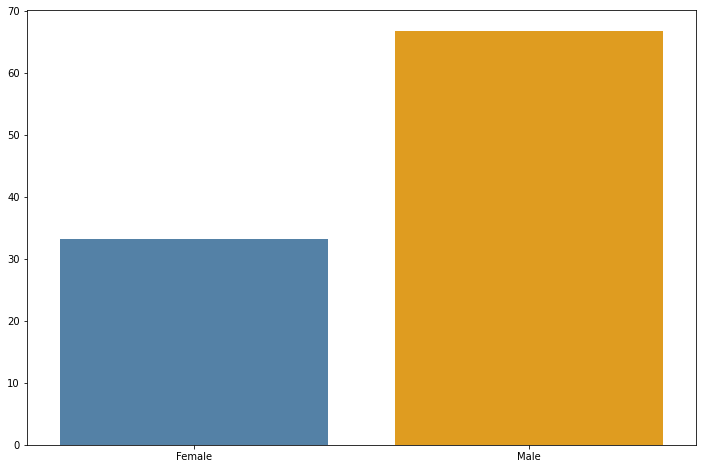

In [37]:
mf_ratio = sensitive_features.value_counts(normalize=True) * 100

plt.figure(figsize=(12,8))
sns.barplot(x=mf_ratio.index, y=mf_ratio.values, palette=['steelblue', 'orange'])

In [42]:
df2 = df.copy()
df2['target'] = data.target

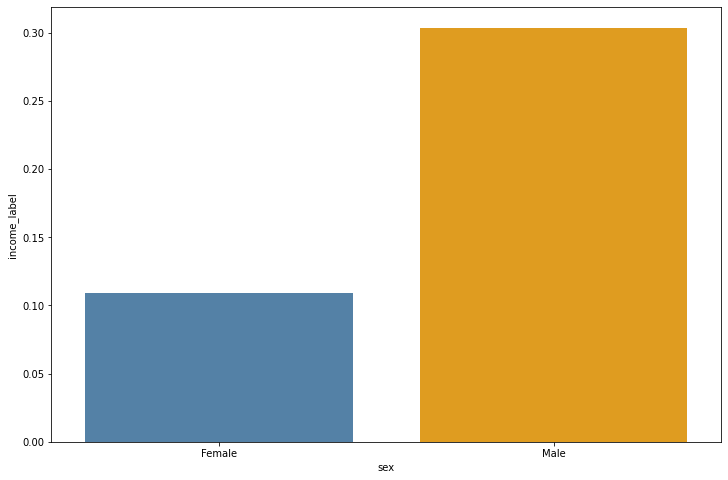

In [49]:
gender_income_grp_df = df2.groupby('sex')['target'].value_counts(normalize=True).to_frame('income_label').reset_index()
gender_income_grp_df = gender_income_grp_df[gender_income_grp_df['level_1']=='>50K']


plt.figure(figsize=(12,8))
sns.barplot(x=gender_income_grp_df['sex'], y=gender_income_grp_df['income_label'], palette=['steelblue', 'orange'])

## Modelling Pipeline

In [9]:
numeric_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scaler", StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            LogisticRegression(solver="liblinear", fit_intercept=True),
        ),
    ]
)

In [10]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9570538e0>),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [11]:
y_pred = pipeline.predict(X_test)

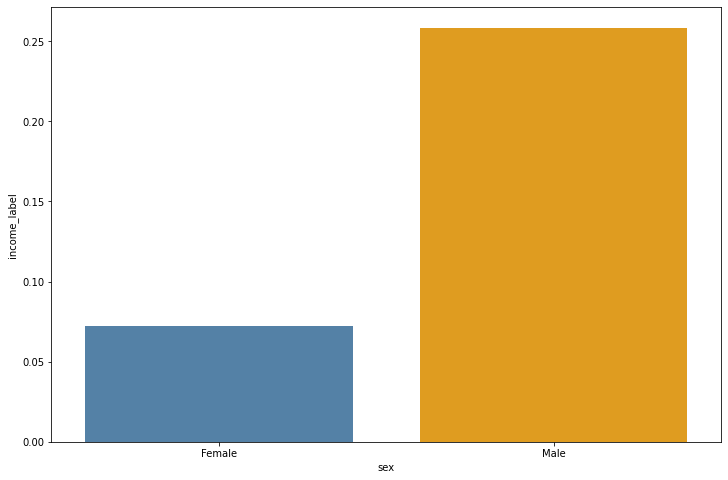

In [53]:
eval_df = pd.DataFrame(A_test)

eval_df['pred'] = y_pred

gender_income_grp_df = eval_df.groupby('sex')['pred'].value_counts(normalize=True).to_frame('income_label').reset_index()
gender_income_grp_df = gender_income_grp_df[gender_income_grp_df['pred']==1]


plt.figure(figsize=(12,8))
sns.barplot(x=gender_income_grp_df['sex'], y=gender_income_grp_df['income_label'], palette=['steelblue', 'orange'])

In [20]:
m_dpr = demographic_parity_ratio(y_test, y_pred, sensitive_features=A_test)
m_eqo = equalized_odds_ratio(y_test, y_pred, sensitive_features=A_test)
print(f'Value of demographic parity ratio: {round(m_dpr, 2)}')
print(f'Value of equal odds ratio: {round(m_eqo, 2)}')


Value of demographic parity ratio: 0.28
Value of equal odds ratio: 0.23


## Model Post-Processing 

In [14]:
threshold_optimizer = ThresholdOptimizer(
    estimator=pipeline,
    constraints="demographic_parity",
    predict_method="predict_proba",
    prefit=False,
)


In [15]:
threshold_optimizer.fit(X_train, y_train, sensitive_features=A_train)


ThresholdOptimizer(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9570538e0>),
                                                                              ('cat',
                                                                               Pipeline(steps=[('impute',
                                                    

{
    "Female": {
        "p0": 0.8004605263157903,
        "operation0": "[>0.20324499179791708]",
        "p1": 0.19953947368420966,
        "operation1": "[>0.18734127402347453]"
    },
    "Male": {
        "p0": 0.08600930232558156,
        "operation0": "[>0.681999437630642]",
        "p1": 0.9139906976744184,
        "operation1": "[>0.6657102532839321]"
    }
}


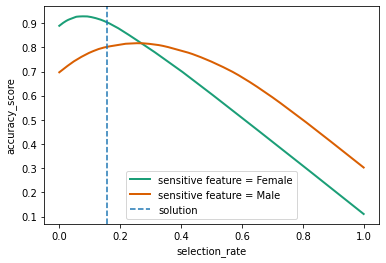

In [16]:
y_pred_opt = threshold_optimizer.predict(X_test, sensitive_features=A_test)

print(
    json.dumps(
        threshold_optimizer.interpolated_thresholder_.interpolation_dict,
        default=str,
        indent=4,
    )
)

plot_threshold_optimizer(threshold_optimizer)

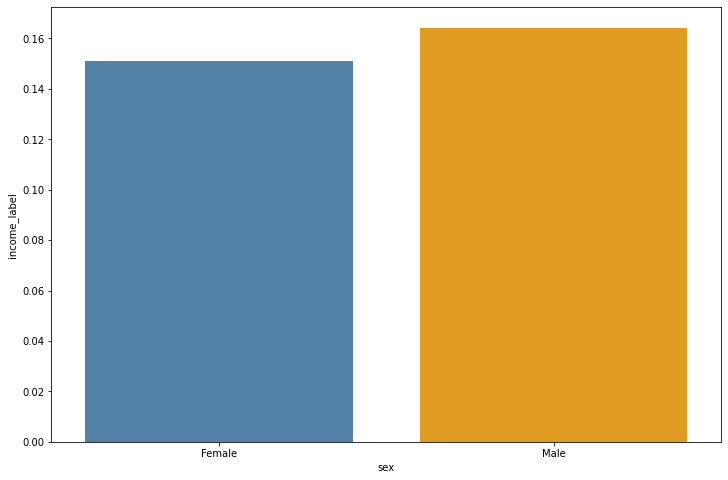

In [54]:
eval_df = pd.DataFrame(A_test)

eval_df['pred'] = y_pred_opt

gender_income_grp_df = eval_df.groupby('sex')['pred'].value_counts(normalize=True).to_frame('income_label').reset_index()
gender_income_grp_df = gender_income_grp_df[gender_income_grp_df['pred']==1]


plt.figure(figsize=(12,8))
sns.barplot(x=gender_income_grp_df['sex'], y=gender_income_grp_df['income_label'], palette=['steelblue', 'orange'])

In [21]:
m_dpr_opt = demographic_parity_ratio(y_test, y_pred_opt, sensitive_features=A_test)
m_eqo_opt = equalized_odds_ratio(y_test, y_pred_opt, sensitive_features=A_test)
print(f'Value of demographic parity ratio (after post-processing): {round(m_dpr_opt, 2)}')
print(f'Value of equal odds ratio (after post-processing): {round(m_eqo_opt, 2)}')

Value of demographic parity ratio (after post-processing): 0.92
Value of equal odds ratio (after post-processing): 0.55
